In [1]:
import shutil
import sys
import os
from glob import glob
from importlib import reload

sys.path.insert(0, "/home/2649/repos/TRANSSClass/scripts")
import TRANSSC_utils

"""Import community packages"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ModuleNotFoundError:
    import tensorflow as tf

"""Import packages written for SNIDsn, astrodash, and Willow Fortino's (me) dgspec."""
import SNIDsn
import SNIDdataset as snid
import SNePCA

import degrade
import kernels
import plotutils
import utils
import classify_PCASVC as cps

import create_training_set as cts
import training_parameters as tp
import deep_learning_multilayer as dlm
import model_metrics as mm
from multilayer_convnet import convnet_variables

R_vals = [
    738, 700, 600, 500, 400, 300,
    200, 175, 150, 125, 100,
    90, 80, 70, 60, 50,
    45, 40, 35, 30, 25, 20, 15, 10, 5
]

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def plot_DASH_cm(training_set_dir, BACKUP_DIR):
    trainImages = np.load(
        os.path.join(training_set_dir, "trainImages.npy"),
        mmap_mode="r")
    trainLabels = np.load(
        os.path.join(training_set_dir, "trainLabels.npy"),
        mmap_mode="r")

    testImages = np.load(
        os.path.join(training_set_dir, "testImages.npy"),
        mmap_mode="r")
    testLabelsIndexes = np.load(
        os.path.join(training_set_dir, "testLabels.npy"),
        mmap_mode="r")

    typeNamesList = np.load(
        os.path.join(training_set_dir, "typeNamesList.npy"),
        mmap_mode="r")
    testTypeNames = np.load(
        os.path.join(training_set_dir, "testTypeNames.npy"),
        mmap_mode="r")

    reload(mm)
    cm0 = mm.calc_model_metrics(
        BACKUP_DIR,
        testLabelsIndexes,
        testImages,
        testTypeNames,
        typeNamesList,
        fig_dir=".")

In [3]:
plt.style.use("https://raw.githubusercontent.com/FoxFortino/stylefile/master/custom.mplstyle")

In [4]:
LIBRARY_PATH = "/lustre/lrspec/users/2649/degraded_spectra_library"

# SAVE_DIR = "/lustre/lrspec/users/2649/models/DASH_split_by_sn"
SAVE_DIR = "/lustre/lrspec/users/2649/models/DASH_split_by_spectra"

R = 738

In [5]:
snidTemplateLocation = os.path.join(LIBRARY_PATH, str(R), "lnw_files")
R_dir = os.path.join(SAVE_DIR, str(R))
BACKUP_DIR = os.path.join(R_dir, "backup")
training_set_dir = os.path.join(R_dir,  "training_set")
history = pd.read_csv(os.path.join(R_dir, "history.csv"))

In [6]:
trainImages = np.load(
    os.path.join(training_set_dir, "trainImages.npy"),
    mmap_mode="r")
trainLabels = np.load(
    os.path.join(training_set_dir, "trainLabels.npy"),
    mmap_mode="r")

testImages = np.load(
    os.path.join(training_set_dir, "testImages.npy"),
    mmap_mode="r")
testLabelsIndexes = np.load(
    os.path.join(training_set_dir, "testLabels.npy"),
    mmap_mode="r")

typeNamesList = np.load(
    os.path.join(training_set_dir, "typeNamesList.npy"),
    mmap_mode="r")
testTypeNames = np.load(
    os.path.join(training_set_dir, "testTypeNames.npy"),
    mmap_mode="r")

In [7]:
MODEL_DIR = BACKUP_DIR

In [8]:
tf.reset_default_graph()
nw = len(testImages[0])
nBins = len(typeNamesList)
imWidthReduc = 8
imWidth = 32  # Image size and width

x, y_, keep_prob, y_conv, W, b = convnet_variables(imWidth, imWidthReduc, nw, nBins)

saver = tf.train.Saver()
with tf.Session() as sess:
    index_files = glob(os.path.join(MODEL_DIR, "*.index"))
    latest_ckpt = max(index_files, key=os.path.getctime)
    saver = tf.train.Saver()
    saver.restore(sess, latest_ckpt.split(".index")[0])

    Y_prd = y_conv.eval(feed_dict={x: testImages, keep_prob: 1.0})
Y_prd = np.argmax(Y_prd, axis=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from /lustre/lrspec/users/2649/models/DASH_split_by_spectra/738/backup/model-79600


2022-07-26 22:15:46.411367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/shared/slurm/lib:/lustre/lrspec/users/2649/anaconda3/envs/fox/lib/:/lustre/lrspec/users/2649/anaconda3/envs/fox/lib/
2022-07-26 22:15:46.414850: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-26 22:15:46.414885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r1n25): /proc/driver/nvidia/version does not exist
2022-07-26 22:15:46.421926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appro

In [9]:
# Need to discount Type II-pec from analysis
classes_per_subtype = 18
num_classes = 306
SubTypeIndices = np.arange(0, num_classes + 1, classes_per_subtype)
SubTypeIndices, SubTypeIndices.shape

(array([  0,  18,  36,  54,  72,  90, 108, 126, 144, 162, 180, 198, 216,
        234, 252, 270, 288, 306]),
 (18,))

In [10]:
Y_tst_SubType = np.digitize(testLabelsIndexes, SubTypeIndices) - 1
Y_prd_SubType = np.digitize(Y_prd, SubTypeIndices) - 1

In [11]:
cm_tst = sklearn.metrics.confusion_matrix(Y_tst_SubType, Y_prd_SubType)

In [12]:
TRANSSC_utils.SNtypes_int = np.unique(Y_tst_SubType)
TRANSSC_utils.SNtypes_str = [TRANSSC_utils.SNtypes_int_to_str[sn] for sn in TRANSSC_utils.SNtypes_int]

In [13]:
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.major.width"] = 1

plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.major.width"] = 1

plt.rcParams["axes.linewidth"] = 1

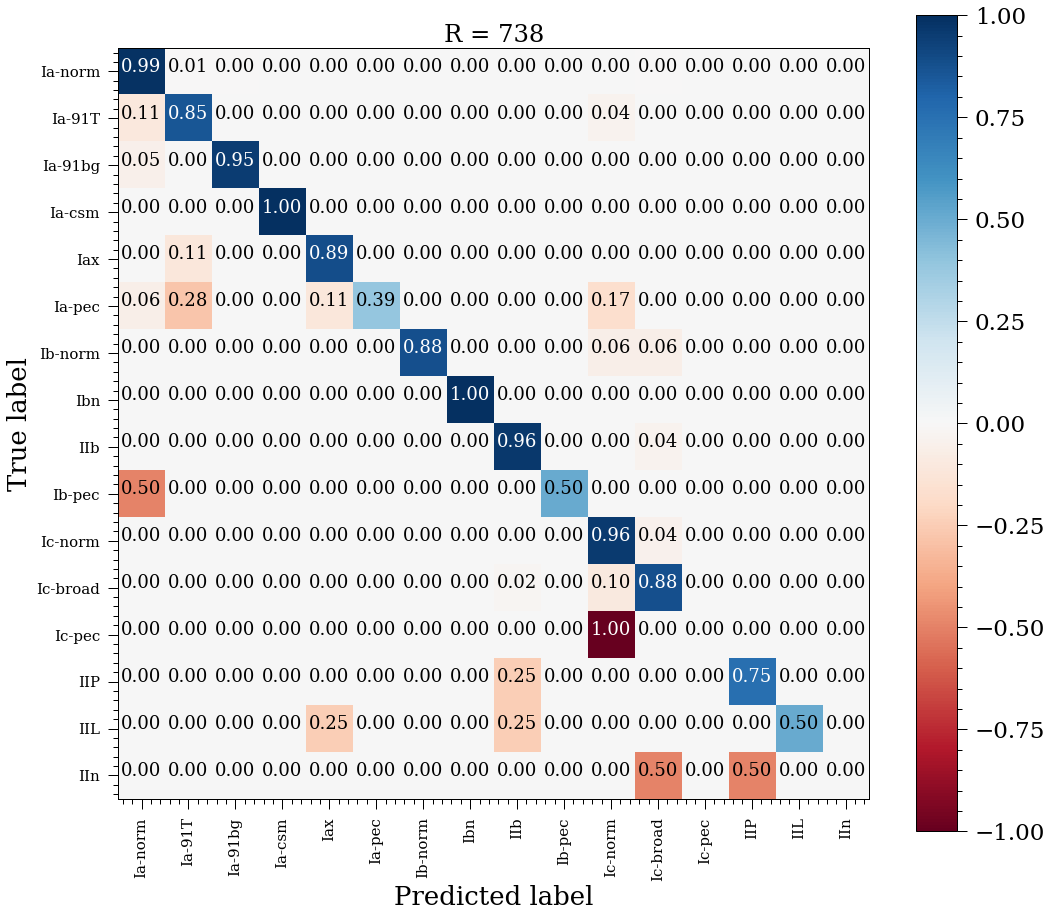

In [14]:
TRANSSC_utils.plot_cm(
    cm_tst,
    TRANSSC_utils.SNtypes_str,
    R,
    normalize=True,
    figsize=(15, 13),
    fontsize_offset=0)